# <u>💡Faces Generation Using DCGAN💡</u>

## <u> Introduction </u>

In this project, I will be implementing the
[Deep Convolutional Generative Adverserial Network(DCGAN)](https://arxiv.org/abs/1511.06434v2)
by Alec Radford, Luke Metz and Soumith Chintala.

We will be using the Flickr-Faces-HQ Dataset (FFHQ) for this project. <a src="https://github.com/NVlabs/ffhq-dataset">Link to Dataset.</a>

DCGAN, or Deep Convolutional Generative Adversarial Network, is a generative adversarial network architecture. It uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. The generator produces synthetic images resembling training images, while the discriminator distinguishes between real and fake images. It replaces pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

In the following sections, we will be going stage by stage, building out the pipeline till completion.

In [30]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In the following 2 cells, we define some variables which are:

* DATA_DIR: Represents the directory where our input resides
* stats: mean and standard deviation for the 3 input channels in images which we will use to achieve a range of values of [-1, 1]

and then we review some of the files in our training directory.

In [2]:
DATA_DIR = 'c:\\Users\\BassilOraby\\Desktop\\DevisionX Bootcamp Assignments\\Final Project\\'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
print(os.listdir(DATA_DIR+'flickrfaceshq-dataset-ffhq')[:10])

['27147.png', '52235.png', '32352.png', '41695.png', '21130.png', '36145.png', '22897.png', '18966.png', '22069.png', '47434.png']


# <u>Creating Dataset Object and Dataloader</u>

A dataloader is a useful tool in PyTorch that allows you to load data from a dataset in an efficient and convenient way. A dataloader can:

* Automatically batch the data into mini-batches of a specified size.
* Shuffle the data to avoid sampling bias and improve generalization.
* Parallelize the data loading process using multiple workers to speed up the training.
* Apply custom transformations to the data before feeding it to the model.
* Handle different types of datasets, such as map-style or iterable-style.
To use a dataloader, you need to pass a dataset object and some optional arguments to the DataLoader constructor as follows:

In [4]:
def get_dataloader(image_size, batch_size):
    train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)]))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dl

In [5]:
image_size = 64
batch_size = 64

train_dl = get_dataloader(image_size, batch_size)

Following function is for denormalizing images to attain them back as normal images:

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# <u> Visualization</u>

In the following Block of code, We work on visualizing our dataset through viewing a batch of torch tensors using matplotlib:

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

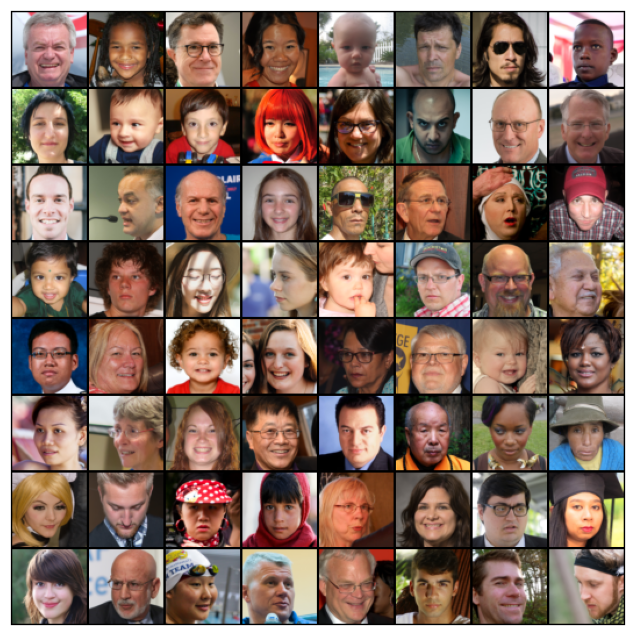

In [8]:
show_batch(train_dl)

In the following cell, we'll be taking advantage of the gpu hardware offered by our computing system to perform the networks training and evaluation:

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In the following cell, we create a wrapper for our dataloader to be able to interface with the GPU:

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

# <u>DCGANs Architecture</u>

Deep Convolutional Generative Adverserial Networks(DCGANs) are networks that are built mainly on the idea of convolutional neural networks (CNNs) but with the advent of using Generative adverserial concepts, where two networks are competing against each other in an attempt for one of them to beat the other, namely we'll be talking about Generator and Discriminator Networks and how we can utilize these networks in our goal for this project, following is the architecture of the model we'll be using:

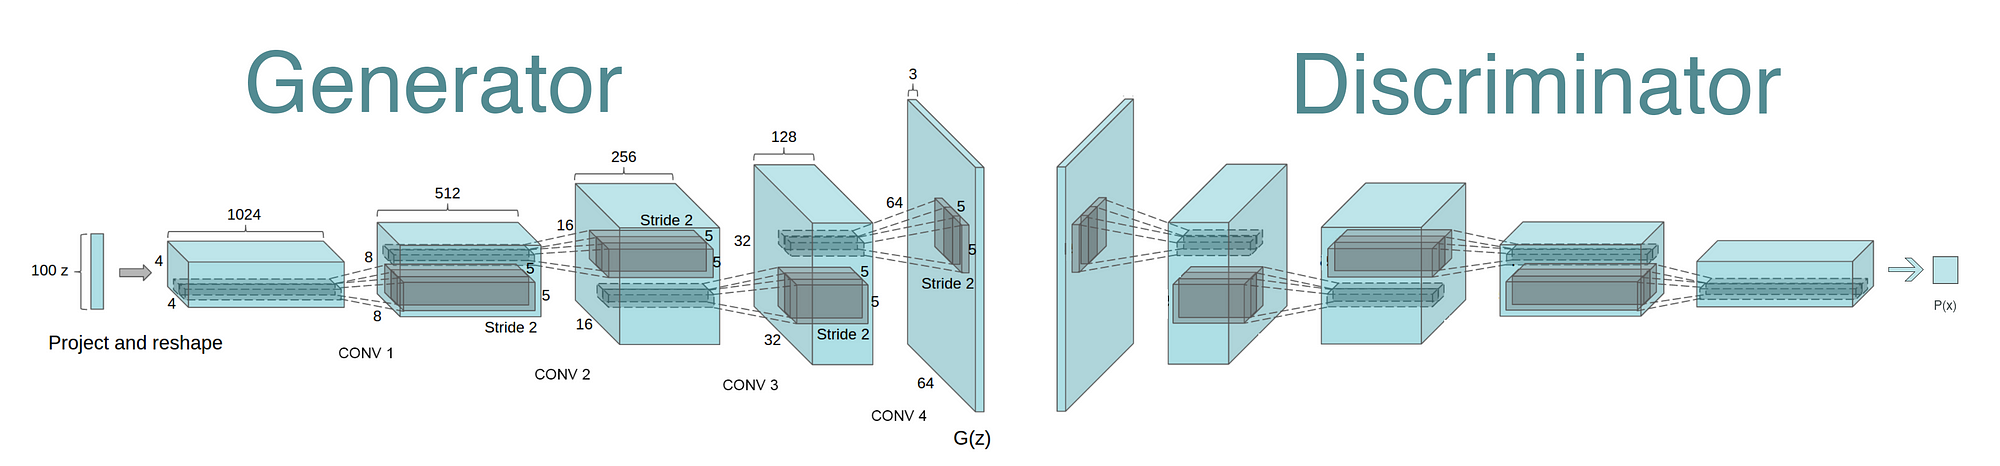

Bear in mind that, we will not be constructing every single layer in the architecture as it's too much with respect to computational and space complexity and hard to be trained given the average computational power at hand and the limited time.

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural network (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*tUhgr3m54Qc80GU2BkaOiQ.gif" width="80%" height="400" style="display:block; margin-left:auto; margin-right:auto;"/>

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which acts as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://miro.medium.com/max/1400/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([64, 3, 64, 64])
64


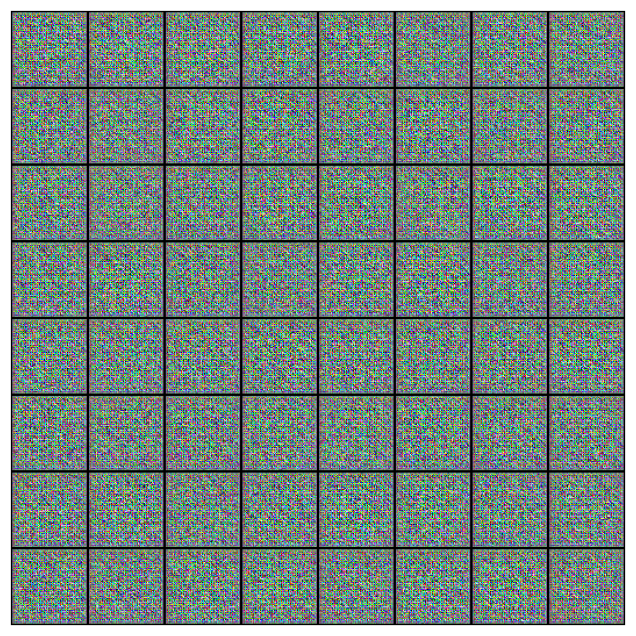

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
generator = to_device(generator, torch.device('cpu'))
fake_images = generator(xb)
print(fake_images.shape)
print(batch_size)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/07/Binary_Cross_Entropy.gif" width="65%" >

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


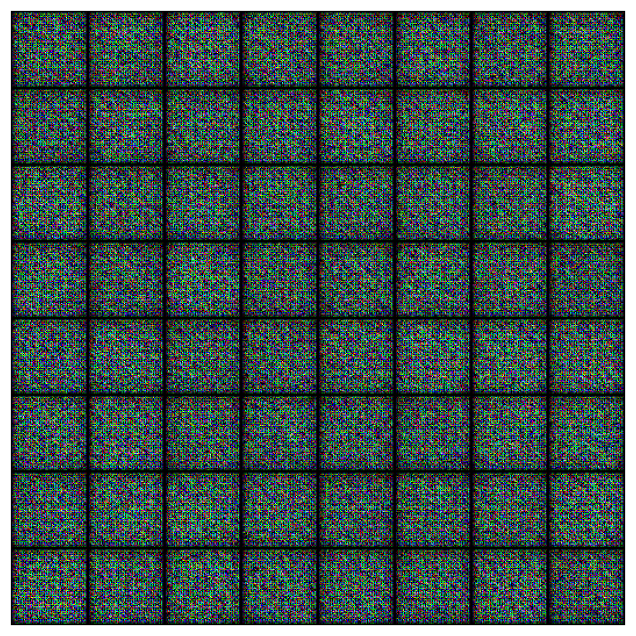

In [23]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0002
epochs = 25

In [26]:
history = fit(epochs, lr)

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.2667, loss_d: 0.2552, real_score: 0.8561, fake_score: 0.0779
Saving generated-images-0001.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.5537, loss_d: 0.4127, real_score: 0.8476, fake_score: 0.1846
Saving generated-images-0002.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.8363, loss_d: 0.4073, real_score: 0.9531, fake_score: 0.2765
Saving generated-images-0003.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.1732, loss_d: 0.4214, real_score: 0.9843, fake_score: 0.2911
Saving generated-images-0004.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.4305, loss_d: 0.4582, real_score: 0.9536, fake_score: 0.2863
Saving generated-images-0005.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 3.2307, loss_d: 0.3657, real_score: 0.7886, fake_score: 0.0714
Saving generated-images-0006.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7566, loss_d: 0.8121, real_score: 0.5704, fake_score: 0.0595
Saving generated-images-0007.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 2.5172, loss_d: 0.3896, real_score: 0.8447, fake_score: 0.1650
Saving generated-images-0008.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 7.4614, loss_d: 0.9420, real_score: 0.9322, fake_score: 0.5070
Saving generated-images-0009.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 2.1667, loss_d: 0.3338, real_score: 0.8306, fake_score: 0.0911
Saving generated-images-0010.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.1951, loss_d: 0.2908, real_score: 0.9747, fake_score: 0.2094
Saving generated-images-0011.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 1.0299, loss_d: 0.5026, real_score: 0.6887, fake_score: 0.0636
Saving generated-images-0012.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.8805, loss_d: 0.3561, real_score: 0.8744, fake_score: 0.1428
Saving generated-images-0013.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.3303, loss_d: 0.2641, real_score: 0.8342, fake_score: 0.0519
Saving generated-images-0014.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.2643, loss_d: 0.2122, real_score: 0.9003, fake_score: 0.0844
Saving generated-images-0015.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.9217, loss_d: 0.0789, real_score: 0.9551, fake_score: 0.0300
Saving generated-images-0016.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.9356, loss_d: 0.4063, real_score: 0.9936, fake_score: 0.2567
Saving generated-images-0017.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.4450, loss_d: 1.6084, real_score: 0.9962, fake_score: 0.6644
Saving generated-images-0018.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.8076, loss_d: 0.1523, real_score: 0.9790, fake_score: 0.1118
Saving generated-images-0019.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.8196, loss_d: 0.0883, real_score: 0.9693, fake_score: 0.0516
Saving generated-images-0020.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.1064, loss_d: 0.0978, real_score: 0.9279, fake_score: 0.0186
Saving generated-images-0021.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 6.0509, loss_d: 0.0337, real_score: 0.9846, fake_score: 0.0174
Saving generated-images-0022.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.1221, loss_d: 0.2131, real_score: 0.8523, fake_score: 0.0306
Saving generated-images-0023.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.2973, loss_d: 0.2220, real_score: 0.9943, fake_score: 0.1561
Saving generated-images-0024.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.6355, loss_d: 0.0586, real_score: 0.9817, fake_score: 0.0365
Saving generated-images-0025.png


In [27]:
losses_g, losses_d, real_scores, fake_scores = history

In the following cell, we would like to save the weights achieved by our discriminator and generator networks so as to be able to use them or refine them later on.

In [28]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## <u> Evaluation </u>
In this stage, we will be evaluating the performance of our model through reviewing the gradual improvement in images generation on one hand, and also reviewing the temporal changes in the losses and scores of real and fake sets on the other hand.

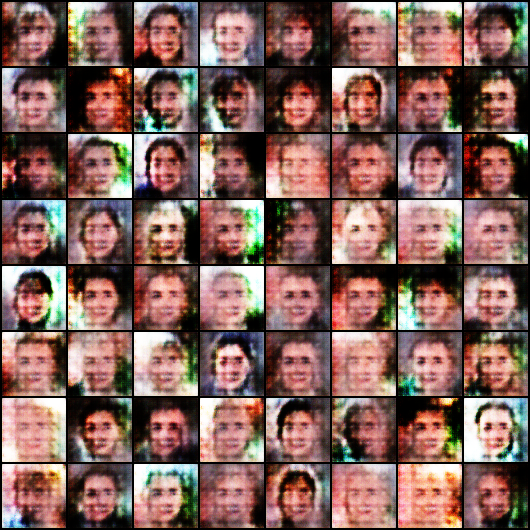

In [31]:
Image('./generated/generated-images-0001.png')

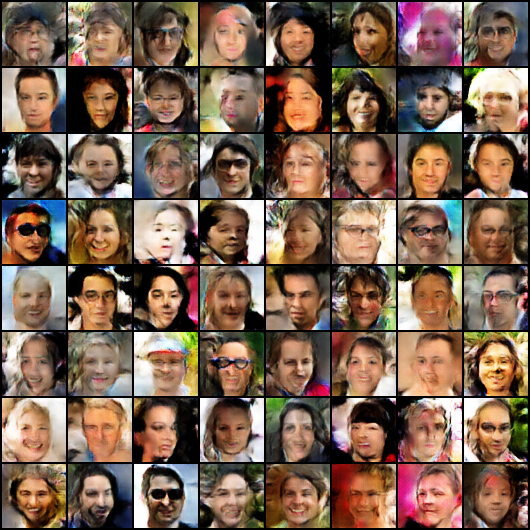

In [32]:
Image('./generated/generated-images-0005.png')

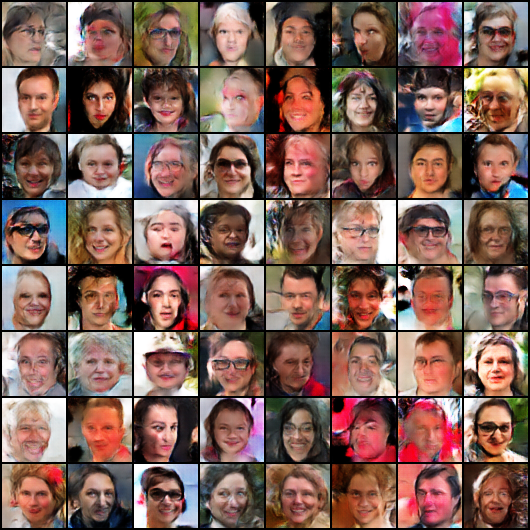

In [33]:
Image('./generated/generated-images-0010.png')

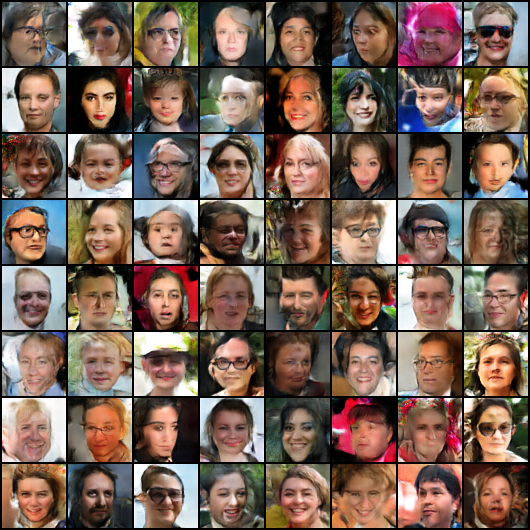

In [34]:
Image('./generated/generated-images-0020.png')

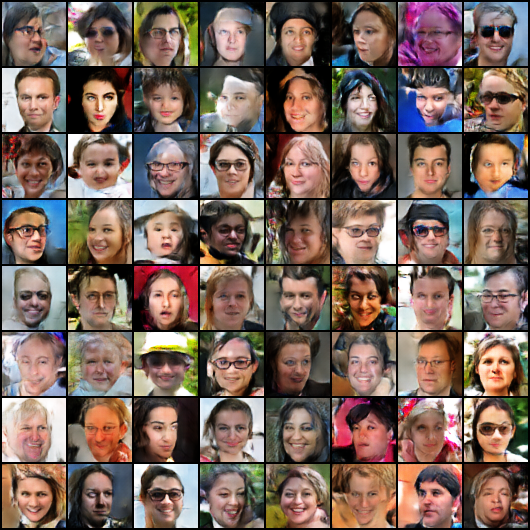

In [35]:
Image('./generated/generated-images-0025.png')

In the following cell, we will create a video consisiting of all the generated image sets during the whole training process with the help of opencv:

In [36]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


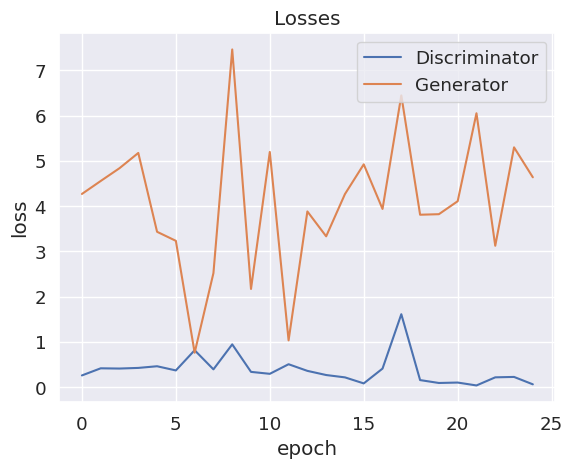

In [37]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

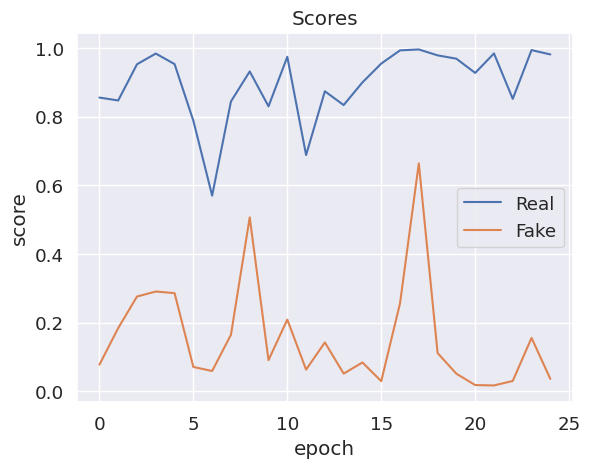

In [38]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

#### <u> Interpretation of the previous results </u>

We hope to achieve the following goals for evaluation:

1. Quality: The generated images should be realistic, sharp, diverse, and match the characteristics of the training data.
2. Diversity: The generated images should cover the different modes or categories of the training data, and avoid mode collapse or mode dropping.
3. Stability: The training process should be stable and converge to a good equilibrium between the generator and the discriminator.

<u>Starting with point number 1:</u>
From the previous set of grid images resulting from the generator during training, we can see that the quality of the images is getting better bit by bit, capturing more of the facial expressions, more realistic background scenes, but diversity is not the best.

<u>As for point number 2:</u>
Diversity is not the best because not all ethincities are represented well enough in the generated images, for example, we can see that caucasians and are well represented in the generated images but not the same as for the black people and asians for example.

<u>Finally, for the 3rd point</u>
Of course, it is obvious that convergence has not been reached yet, but thing is, training a gan model is not easy, it requires time and computational resources as well as memory resources, i've trained my model with the available data for only 25 epochs in about 5 hours, given more time, i would have given my model a chance to train for a much longer time which would definitely lead to better results, also another challenge was the memory consumption for this model to train, memory was consumed highly and i've done some workarounds to decrease memory usage and more techniques will be discussed in the following section for future work.

As for the losses and scores graphs:

<u>Losses:</u>
Loss is a measure of how good our generator and discriminator networks are performing, but what are we hoping to achieve out of these loss functions? As for the:

* Generator network: we want to minimize the loss function as much as we can in order to increase the ability of our generator to fool the discriminator into believing that the images it generates are all real, and according to the original GAN research paper by Ian Goodfellow et.al., the proposed ideal generator should reach a value of about -log(4), which according to the graph seem to be still a far fetched goal that is yet to be achieved, namely, the generator network did not converge yet.

* Discriminator network: As for this network's loss function, we are trying to maximize the results as much as we can in order to increase the ability of our discriminator model to differentiate between real and fake images fed to it by the generator network and the real images probability distribution, and according to the very same paper of GANs by Ian Goodfellow, it is hypothesized that the ideal discriminator loss value should be equal to 0.5 but actually, according to the loss graph, the current discriminator loss readings do not satisfy the required outcome but yet, there is definitely room for improvement and can reach desired results given more time and epochs.

Now according to the scores graph, we can see that the scores do rise heavily to the desired bounded area [0.4:0.6] for the fake images, where the discriminator starts to get confused about whether fake images are real or fake, but not the same for real images, where the real images scores are steadily within the upper bound region on average, which is not the goal for our real images, and we hope that the discriminator will not be able to differentiate between real and fake images on the long run, namely producing average scores of 0.5 for both real and fake images.

## <u> Future Work & Improvements </u>

 Of course we can see that our DCGAN model did not achieve it's best performance yet, neither through visual nor through numerical assessment, and in the following points, we review the methods with which we could improve our results further:

 * <u>Gradient Checkpointing</u>: Gradient checkpointing is a technique used to reduce memory usage by clearing activations of certain layers and recomputing them during a backward pass. Effectively, this trades extra computation time for reduced memory usage.

 * <u>Automatic Mixed Precision</u>: Automatic Mixed Precision is a technique used in deep learning frameworks. It is a method of using both single- and half-precision representations to train deep neural networks. This technique helps to improve performance by more than 3 times on modern GPUs and 60% on TPUs. By keeping certain parts of the model in the 32-bit types for numeric stability, the model will have a lower step time and train equally as well in terms of the evaluation metrics such as accuracy.

 * <u>More Computational Power, More Epochs</u>: it's clearly obvious that in our case, this model can definitely improve given more time and epochs, better yet, is to offer more computational power to achieve desired results in less time.

 * <u>Transfer Learning</u>: Transfer learning is a technique where the knowledge obtained from a model used in one task can be reused as a foundation point for another task. In transfer learning, the knowledge of an already trained model is applied to a different but related problem. This approach involves the use of knowledge that was learned in some task, and apply it to solve the problem in the related target task. We can use this approach to cut down some of the time wasted in waiting for training to complete.

### References:

* <a href="https://www.youtube.com/playlist?list=PLdxQ7SoCLQAMGgQAIAcyRevM8VvygTpCu"> Playlist on GANs derivation & Implementation </a>

* <a href="https://arxiv.org/abs/1511.06434v2">Original Research paper on DCGAN</a>